<a href="https://colab.research.google.com/github/nericovich/project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект для задачи Яндекс Акедемии "Анализ экологических проблем"

### На заводе по производству полезного полимера ООО “Synthesising the future“ обратились за помощью в исследовании зависимостей вредных выбросов от производственных показателей. Требуется повести анализ данных и построить выводы о том, какой этап имеет высокий риск создать повышенное содержания вредного газа.


## Импорты

In [ ]:
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind, shapiro

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/АД  2  Экология/data.csv', sep=',', skipinitialspace=True)

## Main


### Обработка

In [ ]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

### Распределние

<Axes: xlabel='stage_1_output_konv_avd', ylabel='Density'>

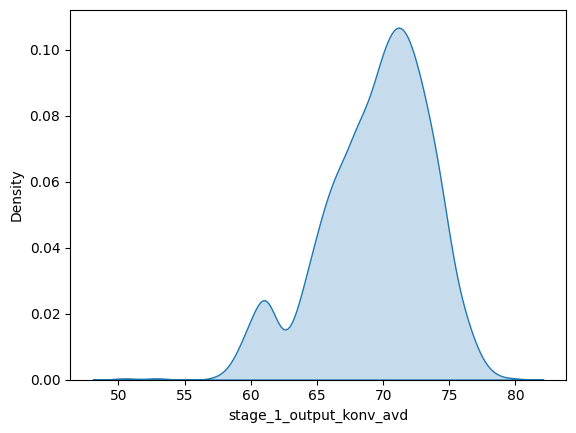

In [ ]:
sns.kdeplot(data=df, x='stage_1_output_konv_avd', fill=True)

In [ ]:
sns.kdeplot(data=df, x='stage_2_input_water_sum', fill=True)

In [ ]:
sns.kdeplot(data=df, x='stage_2_output_bottom_pressure', fill=True)

In [ ]:
sns.kdeplot(data=df, x='stage_2_output_bottom_temp', fill=True)

In [ ]:
sns.kdeplot(data=df, x='stage_2_output_top_pressure', fill=True)

In [ ]:
sns.kdeplot(data=df, x='stage_2_output_top_pressure_at_end', fill=True)

In [ ]:
sns.kdeplot(data=df, x='stage_3_input_pressure', fill=True)

In [ ]:
sns.kdeplot(data=df, x='stage_3_output_temp_hum_steam', fill=True)

In [ ]:
sns.kdeplot(data=df, x='stage_3_output_temp_top', fill=True)

In [ ]:
sns.kdeplot(data=df, x='stage_4_input_overheated_steam', fill=True)

In [ ]:
sns.kdeplot(data=df, x='stage_4_output_danger_gas', fill=True)

In [ ]:
sns.kdeplot(data=df, x='work_shift', fill=True)